In [1]:
# !pip install xgboost

In [2]:
# !pip install category_encoders

In [3]:
# !pip install keras

In [139]:
## Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,adjusted_rand_score
from xgboost import XGBRegressor
from statsmodels.stats.anova import anova_lm
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from scipy.stats import stats
from category_encoders import *
import category_encoders as ce
pd.set_option('display.max_columns',30)
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import FunctionTransformer
from scipy.stats import bartlett, levene, shapiro
from catboost import CatBoostRegressor
from catboost import Pool, cv
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt 
import pickle 
import streamlit as st 
from PIL import Image 
import warnings
warnings.filterwarnings('ignore')

In [140]:
import catboost

In [141]:
catboost.__version__

'0.24.2'

In [5]:
# !pip install tensorflow == 2.2

In [6]:
## Loading the dump data

df = pd.read_csv('Oct spares data.csv')

In [7]:
df.head(5)

,Unnamed: 0,amount,channel_reference,customer_id,customer_name,customer_type,invoice_dt,invoice_number,items,order_date,order_id,order_net_amount,order_status,quantity,shipping_state,sku_id,sku_name,source,user_name,warehouse_name,order_dt,pending_orders,overdue_days,channel
0,27998,433.50,NaN,1350,Aum Motors,GoPreneur,2020-10-08 00:00:00,D_OUT/20-21/2355,MGP,2020-08-07 19:13:18,GMD2307,2167.513600,Invoiced,10.0,Gujarat,72321M67L00,LINING FRONT FENDER RH,Offline,gp_rahul,GM_DEL,2020-08-07 19:13:18,0,0,GoPreneur
1,31392,23406.22,NaN,1350,Aum Motors,GoPreneur,2020-10-15 00:00:00,D_OUT/20-21/2582,VW GROUP,2020-08-17 18:26:41,GMD2425,224420.625000,Invoiced,15.0,Gujarat,6RF8536519B9,GRILLE UPPER,Offline,d_lalit,GM_DEL,2020-08-17 18:26:41,0,0,GoPreneur
2,31400,2297.09,NaN,1350,Aum Motors,GoPreneur,2020-10-15 00:00:00,D_OUT/20-21/2582,VW GROUP,2020-08-17 18:26:41,GMD2425,2297.110000,Invoiced,5.0,Gujarat,6RG8536779B9,GRILLE LOWER,Offline,d_lalit,GM_DEL,2020-08-17 18:26:41,0,0,GoPreneur
3,31405,8172.81,NaN,1350,Aum Motors,GoPreneur,2020-10-15 00:00:00,D_OUT/20-21/2582,VW GROUP,2020-08-17 18:26:41,GMD2425,8172.834048,Invoiced,2.0,Gujarat,6RU807421GRU,COVER,Offline,d_lalit,GM_DEL,2020-08-17 18:26:41,0,0,GoPreneur
4,31410,16062.05,NaN,1350,Aum Motors,GoPreneur,2020-10-15 00:00:00,D_OUT/20-21/2582,VW GROUP,2020-08-17 18:26:41,GMD2425,16062.040000,Invoiced,3.0,Gujarat,6RU823031,HOOD,Offline,d_lalit,GM_DEL,2020-08-17 18:26:41,0,0,GoPreneur


In [8]:
X = df.drop('order_net_amount', axis = 1)
y = df['order_net_amount']

In [9]:
## To avoid Data leakage, lets split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [10]:
df.shape

(14966, 24)

In [11]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10476, 23)
(4490, 23)
(10476,)
(4490,)


In [12]:
df.sku_id.nunique()

6703

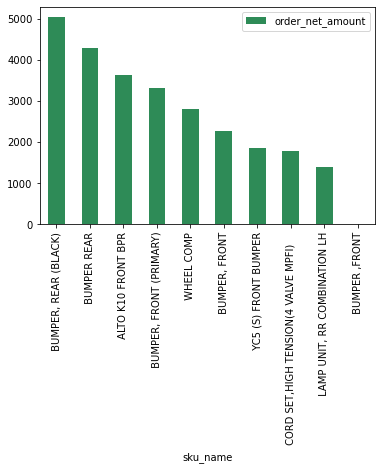

In [13]:
df.groupby('sku_name')[['order_net_amount']].mean().head(10).sort_values(by='order_net_amount',ascending = False).plot(kind='bar', color='seagreen')

In [14]:
df.customer_id.nunique()

248

In [15]:
## Dropping columns which are not necessary for our analysis: Unnamed, channel_reference, customer_id, customer_name, invoice_dt, invoice_number,
## order_date, order_id,channel, sku_id, user_name and can do further feature selection techniques and remove redundant
## columns accordingly.

In [16]:
X_train.head()

,Unnamed: 0,amount,channel_reference,customer_id,customer_name,customer_type,invoice_dt,invoice_number,items,order_date,order_id,order_status,quantity,shipping_state,sku_id,sku_name,source,user_name,warehouse_name,order_dt,pending_orders,overdue_days,channel
14928,69352,0.00,NaN,1425,J S Exports,Exports,NaN,NaN,NISSAN,2020-10-22 13:54:25,GMM1808,Open,10.0,Maharashtra,543028530R,"ABS-SHOCK, FR R",Offline,m_raju,GM_BOM,2020-10-22 13:54:25,1,1,Exports
13788,68212,0.00,NaN,1146,Karan Maruti Spares,Retailers,NaN,NaN,NISSAN,2020-10-21 16:38:41,GP345,Open,2.0,Uttar Pradesh,140356151R,GSKT-INTAKE MAN,offline,gp_rahul,GM_DEL,2020-10-21 16:38:41,1,2,GoPreneur
10839,65263,19844.35,NaN,1319,Esskay Carz Parts,Retailers,2020-10-16 00:00:00,B_OUT/20-21/406,MGP,2020-10-16 15:16:29,GMBX0008,Invoiced,6.0,Kerala,41069M75J41,STRUT SET RH (SWIFT DIESEL HB NB),OFFLINE,priya_b,GM_BLR,2020-10-16 15:16:29,0,0,Retailers - South
7051,61475,225.00,NaN,1577,Arihant Car Parts,Retailers,2020-10-19 00:00:00,M_OUT/20-21/732,MGP,2020-10-10 17:52:56,GMM1705,Invoiced,1.0,Maharashtra,82202M79G90,FRONT DOOR LATCH LH,Offline,m_raju,GM_BOM,2020-10-10 17:52:56,0,0,Retailers - West
1690,56114,0.00,NaN,1146,Karan Maruti Spares,Retailers,NaN,NaN,NISSAN,2020-10-01 17:35:48,GP301,Open,1.0,Uttar Pradesh,788269352R,LOCK & ROD ASSY,offline,gp_rahul,GM_DEL,2020-10-01 17:35:48,1,22,GoPreneur


In [17]:
X_train1 = X_train.drop(['Unnamed: 0','invoice_dt', 'customer_id','channel_reference','invoice_number','channel','customer_name','order_date','order_dt','user_name','order_id','sku_id'],axis = 1)
X_test1 = X_test.drop(['Unnamed: 0','invoice_dt', 'customer_id','channel_reference','invoice_number','channel','customer_name','order_date','order_dt','user_name','order_id','sku_id'],axis = 1)

In [18]:
print(X_train1.shape)
print(X_test1.shape)

(10476, 11)
(4490, 11)


In [19]:
X_train1['shipping_state'].value_counts()

Delhi               2287
Maharashtra         1515
Gujarat             1299
Uttar Pradesh       1095
Haryana              871
Tamil Nadu           690
Telangana            640
Kerala               504
Karnataka            477
Chandigarh           414
West Bengal          160
Punjab               130
Gujrat               117
Ladakh               103
Rajasthan             55
Jharkhand             35
Tamil nadu            23
Maharastra            20
JHARKHAND             18
Maharashtra            7
UP                     6
Madhya Pradesh         3
maharashtra            3
Goa                    2
Maharashtra            1
Arunchal Pradesh       1
Name: shipping_state, dtype: int64

In [20]:
X_test['shipping_state'].value_counts()

Delhi            1001
Maharashtra       630
Gujarat           579
Uttar Pradesh     417
Haryana           350
Tamil Nadu        304
Telangana         275
Kerala            214
Karnataka         208
Chandigarh        190
West Bengal        74
Punjab             63
Gujrat             58
Ladakh             49
Rajasthan          21
Jharkhand          20
Tamil nadu         10
JHARKHAND           8
Maharastra          8
UP                  6
Goa                 3
maharashtra         1
Maharashtra         1
Name: shipping_state, dtype: int64

In [21]:
## Let's combine the same states

In [22]:
X_train1['shipping_state'] = X_train1['shipping_state'].replace({'Maharastra':'Maharashtra','maharashtra':'Maharashtra','UP':'Uttar Pradesh',
                                                     'Gujrat':'Gujarat','JHARKHAND':'Jharkhand','Tamil Nadu':'Tamil nadu'})
X_test1['shipping_state'] = X_test1['shipping_state'].replace({'Maharastra':'Maharashtra','maharashtra':'Maharashtra','UP':'Uttar Pradesh',
                                                     'Gujrat':'Gujarat','JHARKHAND':'Jharkhand','Tamil Nadu':'Tamil nadu'})

In [23]:
X_train1['shipping_state'] = X_train1['shipping_state'].apply(lambda x:str(x).strip())
X_test1['shipping_state'] = X_test1['shipping_state'].apply(lambda x:str(x).strip())

In [24]:
X_train1['shipping_state'].value_counts()

Delhi               2287
Maharashtra         1546
Gujarat             1416
Uttar Pradesh       1101
Haryana              871
Tamil nadu           713
Telangana            640
Kerala               504
Karnataka            477
Chandigarh           414
West Bengal          160
Punjab               130
Ladakh               103
Rajasthan             55
Jharkhand             53
Madhya Pradesh         3
Goa                    2
Arunchal Pradesh       1
Name: shipping_state, dtype: int64

In [25]:
X_test1['shipping_state'].value_counts()

Delhi            1001
Maharashtra       640
Gujarat           637
Uttar Pradesh     423
Haryana           350
Tamil nadu        314
Telangana         275
Kerala            214
Karnataka         208
Chandigarh        190
West Bengal        74
Punjab             63
Ladakh             49
Jharkhand          28
Rajasthan          21
Goa                 3
Name: shipping_state, dtype: int64

In [26]:
print(X_train1['customer_type'].value_counts())
print(X_test1['customer_type'].value_counts())

Retailers    6662
GoPreneur    2249
Workshop     1204
Exports        96
Retailer       14
Name: customer_type, dtype: int64
Retailers    2854
GoPreneur    1000
Workshop      457
Exports        51
Retailer       13
Name: customer_type, dtype: int64


In [27]:
## Let's combine the Retailers and Retailer in one category as Retailer
X_train1['customer_type'] = X_train1['customer_type'].replace({'Retailer':'Retailers'})
X_test1['customer_type'] = X_test1['customer_type'].replace({'Retailer':'Retailers'})

In [28]:
## Checking missing values in X_train and X_test
print(X_train1.isnull().sum())
print(X_test1.isnull().sum())

amount              0
customer_type     251
items               1
order_status        0
quantity            0
shipping_state      0
sku_name            0
source              0
warehouse_name      0
pending_orders      0
overdue_days        0
dtype: int64
amount              0
customer_type     115
items               2
order_status        0
quantity            0
shipping_state      0
sku_name            0
source              0
warehouse_name      0
pending_orders      0
overdue_days        0
dtype: int64


In [29]:
## There are total 366 missing values in X_train and X_test

In [30]:
## Filling missing values in customer_type based on maximum mean amount for each customer_type in different states.

In [31]:
y_train1 = pd.DataFrame(y_train, columns =['order_net_amount'])
y_test1 = pd.DataFrame(y_test, columns =['order_net_amount'])

In [32]:
X_train1.shape

(10476, 11)

In [33]:
y_train1.shape

(10476, 1)

In [34]:
X_train1.head()

,amount,customer_type,items,order_status,quantity,shipping_state,sku_name,source,warehouse_name,pending_orders,overdue_days
14928,0.00,Exports,NISSAN,Open,10.0,Maharashtra,"ABS-SHOCK, FR R",Offline,GM_BOM,1,1
13788,0.00,Retailers,NISSAN,Open,2.0,Uttar Pradesh,GSKT-INTAKE MAN,offline,GM_DEL,1,2
10839,19844.35,Retailers,MGP,Invoiced,6.0,Kerala,STRUT SET RH (SWIFT DIESEL HB NB),OFFLINE,GM_BLR,0,0
7051,225.00,Retailers,MGP,Invoiced,1.0,Maharashtra,FRONT DOOR LATCH LH,Offline,GM_BOM,0,0
1690,0.00,Retailers,NISSAN,Open,1.0,Uttar Pradesh,LOCK & ROD ASSY,offline,GM_DEL,1,22


In [35]:
train_data = pd.concat([X_train1, y_train], axis = 1)  ## Containing target as well
test_data = pd.concat([X_test1, y_test], axis = 1)

In [36]:
train_data.columns

Index(['amount', 'customer_type', 'items', 'order_status', 'quantity',
       'shipping_state', 'sku_name', 'source', 'warehouse_name',
       'pending_orders', 'overdue_days', 'order_net_amount'],
      dtype='object')

In [37]:
X_train2 = pd.DataFrame(train_data.groupby(['shipping_state','customer_type'])['order_net_amount'].mean()).reset_index()

In [38]:
X_train2

,shipping_state,customer_type,order_net_amount
0,Arunchal Pradesh,Retailers,52.088400
1,Chandigarh,Retailers,7004.192765
2,Delhi,Exports,4959.664299
3,Delhi,Retailers,9854.150127
4,Delhi,Workshop,4997.646091
5,Goa,Retailers,4788.749400
6,Gujarat,GoPreneur,5492.103587
7,Gujarat,Workshop,5614.145625
8,Haryana,Retailers,2171.429956
9,Haryana,Workshop,3753.640678


In [39]:
X_train3 = X_train2.groupby('shipping_state').agg({'order_net_amount':max}).reset_index()

In [40]:
X_train3

,shipping_state,order_net_amount
0,Arunchal Pradesh,52.088400
1,Chandigarh,7004.192765
2,Delhi,9854.150127
3,Goa,4788.749400
4,Gujarat,5614.145625
5,Haryana,3753.640678
6,Jharkhand,3091.573893
7,Karnataka,9105.231321
8,Kerala,4620.427962
9,Ladakh,10796.140477


In [41]:
l1=[]
for i,j in zip(X_train2['order_net_amount'],X_train2['customer_type']):
    for k in X_train3['order_net_amount']:
        if (i==k):
            l1.append(j)

In [42]:
l1

['Retailers',
 'Retailers',
 'Retailers',
 'Retailers',
 'Workshop',
 'Workshop',
 'GoPreneur',
 'Retailers',
 'Retailers',
 'GoPreneur',
 'GoPreneur',
 'Retailers',
 'Retailers',
 'Workshop',
 'Retailers',
 'GoPreneur',
 'Workshop',
 'Workshop']

In [43]:
X_train3['customer_type']=l1

In [44]:
X_train3

,shipping_state,order_net_amount,customer_type
0,Arunchal Pradesh,52.088400,Retailers
1,Chandigarh,7004.192765,Retailers
2,Delhi,9854.150127,Retailers
3,Goa,4788.749400,Retailers
4,Gujarat,5614.145625,Workshop
5,Haryana,3753.640678,Workshop
6,Jharkhand,3091.573893,GoPreneur
7,Karnataka,9105.231321,Retailers
8,Kerala,4620.427962,Retailers
9,Ladakh,10796.140477,GoPreneur


In [45]:
dict1 = {i:j for i,j in zip(X_train3['shipping_state'],X_train3['customer_type'])}

In [46]:
dict1

{'Arunchal Pradesh': 'Retailers',
 'Chandigarh': 'Retailers',
 'Delhi': 'Retailers',
 'Goa': 'Retailers',
 'Gujarat': 'Workshop',
 'Haryana': 'Workshop',
 'Jharkhand': 'GoPreneur',
 'Karnataka': 'Retailers',
 'Kerala': 'Retailers',
 'Ladakh': 'GoPreneur',
 'Madhya Pradesh': 'GoPreneur',
 'Maharashtra': 'Retailers',
 'Punjab': 'Retailers',
 'Rajasthan': 'Workshop',
 'Tamil nadu': 'Retailers',
 'Telangana': 'GoPreneur',
 'Uttar Pradesh': 'Workshop',
 'West Bengal': 'Workshop'}

In [47]:
X_train1.isnull().sum()

amount              0
customer_type     251
items               1
order_status        0
quantity            0
shipping_state      0
sku_name            0
source              0
warehouse_name      0
pending_orders      0
overdue_days        0
dtype: int64

In [48]:
cust_null = X_train1[X_train1['customer_type'].isnull()]

In [49]:
cust_null['shipping_state'].value_counts()

Gujarat        117
Maharashtra     63
Punjab          38
Haryana         27
Tamil nadu       6
Name: shipping_state, dtype: int64

In [50]:
cust_null['customer_type'] = cust_null['shipping_state'].map(dict1)

In [51]:
cust_null['customer_type'].value_counts()

Workshop     144
Retailers    107
Name: customer_type, dtype: int64

In [52]:
X_train1.shape

(10476, 11)

In [53]:
X_train1.dropna(subset=['customer_type'],inplace=True)

In [54]:
X_train_data=pd.concat([X_train1,cust_null])

In [55]:
X_train_data.shape

(10476, 11)

In [56]:
X_train_data.isnull().sum()

amount            0
customer_type     0
items             1
order_status      0
quantity          0
shipping_state    0
sku_name          0
source            0
warehouse_name    0
pending_orders    0
overdue_days      0
dtype: int64

In [57]:
## We can replace missing values in items by its mode

In [58]:
X_train_data['items'].fillna(X_train_data['items'].mode()[0],inplace=True)

In [59]:
X_train_data.isnull().sum()

amount            0
customer_type     0
items             0
order_status      0
quantity          0
shipping_state    0
sku_name          0
source            0
warehouse_name    0
pending_orders    0
overdue_days      0
dtype: int64

In [60]:
## Lets check missing values in X_test
X_test1.isnull().sum()

amount              0
customer_type     115
items               2
order_status        0
quantity            0
shipping_state      0
sku_name            0
source              0
warehouse_name      0
pending_orders      0
overdue_days        0
dtype: int64

In [61]:
## Let's use same dict1 that we used in training dataset to fill the missing values in customer_type to avoid the data leakage

In [62]:
cust_null1 = X_test1[X_test1['customer_type'].isnull()]

In [63]:
cust_null1.shape

(115, 11)

In [64]:
cust_null1['customer_type'] = cust_null1['shipping_state'].map(dict1)

In [65]:
X_test1.dropna(subset=['customer_type'],inplace=True)

In [66]:
X_test_data = pd.concat([X_test1,cust_null1])

In [67]:
X_test_data.isnull().sum()

amount            0
customer_type     0
items             2
order_status      0
quantity          0
shipping_state    0
sku_name          0
source            0
warehouse_name    0
pending_orders    0
overdue_days      0
dtype: int64

In [68]:
## Let's impute the missing values in customer_type by its mode
X_test_data['items'].fillna(X_test_data['items'].mode()[0],inplace=True)

In [69]:
X_test_data.isnull().sum()

amount            0
customer_type     0
items             0
order_status      0
quantity          0
shipping_state    0
sku_name          0
source            0
warehouse_name    0
pending_orders    0
overdue_days      0
dtype: int64

In [70]:
X_train_data

,amount,customer_type,items,order_status,quantity,shipping_state,sku_name,source,warehouse_name,pending_orders,overdue_days
14928,0.00,Exports,NISSAN,Open,10.0,Maharashtra,"ABS-SHOCK, FR R",Offline,GM_BOM,1,1
13788,0.00,Retailers,NISSAN,Open,2.0,Uttar Pradesh,GSKT-INTAKE MAN,offline,GM_DEL,1,2
10839,19844.35,Retailers,MGP,Invoiced,6.0,Kerala,STRUT SET RH (SWIFT DIESEL HB NB),OFFLINE,GM_BLR,0,0
7051,225.00,Retailers,MGP,Invoiced,1.0,Maharashtra,FRONT DOOR LATCH LH,Offline,GM_BOM,0,0
1690,0.00,Retailers,NISSAN,Open,1.0,Uttar Pradesh,LOCK & ROD ASSY,offline,GM_DEL,1,22
...,...,...,...,...,...,...,...,...,...,...,...
807,11238.14,Workshop,VW GROUP,Invoiced,4.0,Gujarat,COVER,Offline,GM_DEL,0,0
14368,398.99,Workshop,HYUNDAI,Invoiced,1.0,Haryana,REFLACTOR RR RH,Offline,GM_DEL,0,0
14254,262.10,Retailers,TATA,Invoiced,2.0,Maharashtra,ASSY.RUBBER BUSHING.,Offline,GM_BOM,0,0
7221,400.00,Retailers,VW GROUP,Invoiced,1.0,Maharashtra,VW EMBLEM,Offline,GM_DEL,0,0


In [71]:
print(X_train_data.shape)
print(X_test_data.shape)
print(y_train.shape)
print(y_test.shape)

(10476, 11)
(4490, 11)
(10476,)
(4490,)


In [72]:
y_train

14928    13697.970
13788      289.520
10839    19844.352
7051       225.000
1690       105.280
           ...    
13123     3055.200
3264      1187.990
9845         0.000
10799      893.952
2732       481.600
Name: order_net_amount, Length: 10476, dtype: float64

In [73]:
train_data = pd.concat([X_train_data, y_train], axis = 1)

In [74]:
train_data.groupby('customer_type')['order_net_amount'].mean()

customer_type
Exports      5466.942019
GoPreneur    4987.165298
Retailers    7099.184852
Workshop     3503.308284
Name: order_net_amount, dtype: float64

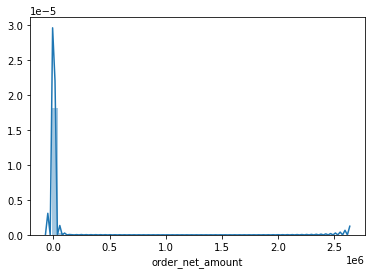

In [75]:
sns.distplot(train_data['order_net_amount'])

In [76]:
transformer = FunctionTransformer(np.cbrt, check_inverse=True)

In [77]:
train_data_ = train_data.copy()

In [78]:
train_data_['order_net_amount'] = transformer.fit_transform(train_data_['order_net_amount'])

In [79]:
train_data_['amount'] = transformer.transform(train_data_['amount'])

In [80]:
train_data_.head()

,amount,customer_type,items,order_status,quantity,shipping_state,sku_name,source,warehouse_name,pending_orders,overdue_days,order_net_amount
0,7.568266,GoPreneur,MGP,Invoiced,10.0,Gujarat,LINING FRONT FENDER RH,Offline,GM_DEL,0,0,12.941579
1,28.605119,GoPreneur,VW GROUP,Invoiced,15.0,Gujarat,GRILLE UPPER,Offline,GM_DEL,0,0,60.769770
2,13.194492,GoPreneur,VW GROUP,Invoiced,5.0,Gujarat,GRILLE LOWER,Offline,GM_DEL,0,0,13.194530
3,20.142984,GoPreneur,VW GROUP,Invoiced,2.0,Gujarat,COVER,Offline,GM_DEL,0,0,20.143003
4,25.230953,GoPreneur,VW GROUP,Invoiced,3.0,Gujarat,HOOD,Offline,GM_DEL,0,0,25.230948


In [81]:
train_data_.skew()

amount               0.883968
quantity            74.028884
pending_orders       0.816239
overdue_days         2.469075
order_net_amount     1.689917
dtype: float64

In [82]:
test_data = pd.concat([X_test_data, y_test], axis = 1)

In [83]:
test_data

,amount,customer_type,items,order_status,quantity,shipping_state,sku_name,source,warehouse_name,pending_orders,overdue_days,order_net_amount
8,3564.69,GoPreneur,VW GROUP,Invoiced,13.0,Gujarat,FENDER,Offline,GM_DEL,0,0,46340.95000
9,10236.48,GoPreneur,VW GROUP,Invoiced,3.0,Gujarat,FENDER,Offline,GM_DEL,0,0,10236.52339
12,38511.36,GoPreneur,VW GROUP,Invoiced,10.0,Gujarat,BUMPER COVER,Offline,GM_DEL,0,0,38511.34000
14,1620.01,GoPreneur,MGP,Invoiced,1.0,Maharashtra,BUMPER FRONT,Offline,GM_DEL,0,0,1620.00000
16,1620.01,GoPreneur,MGP,Invoiced,2.0,Maharashtra,"BUMPER, FRONT (BLACK)",Offline,GM_DEL,0,0,3240.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
14949,0.00,Retailers,MGP,Open,2.0,Maharashtra,MOUNTING COMPENG LH,Offline,GM_BOM,1,1,2154.01000
14953,0.00,Retailers,MGP,Open,12.0,Maharashtra,DISCCLUTCH,Offline,GM_BOM,1,1,24899.94000
14955,0.00,Retailers,MGP,Open,2.0,Maharashtra,STRUT SET RH (SWIFT DIESEL HB NB),Offline,GM_BOM,1,1,7939.99000
14959,0.00,Retailers,MGP,Open,2.0,Maharashtra,COVERCLUTCH(SWIFT PETROL),Offline,GM_BOM,1,1,2700.00000


In [84]:
test_data_ = test_data.copy()

In [85]:
test_data_.skew()

amount              28.463036
quantity            64.855973
pending_orders       0.847873
overdue_days         2.583283
order_net_amount    16.169836
dtype: float64

In [86]:
test_data_['order_net_amount'] = transformer.transform(test_data_['order_net_amount'])

In [87]:
test_data_['amount'] = transformer.transform(test_data_['amount'])

In [88]:
test_data_.skew()

amount               0.959333
quantity            64.855973
pending_orders       0.847873
overdue_days         2.583283
order_net_amount     1.179962
dtype: float64

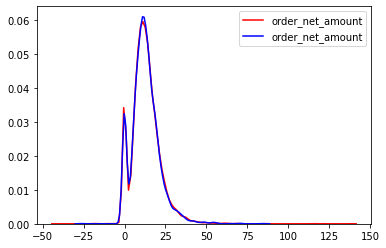

In [89]:
sns.kdeplot(train_data_['order_net_amount'],color='red')
sns.kdeplot(test_data_['order_net_amount'],color='blue')
plt.show()

## <span style="color:blue">Statistical analysis to check significance of variables wrt target </span>

In [90]:
num_cols = train_data_.select_dtypes(['int64','float64']).columns
num_cols

Index(['amount', 'quantity', 'pending_orders', 'overdue_days',
       'order_net_amount'],
      dtype='object')

In [91]:
## Numerical vs Numerical - Bartlett Test 

In [92]:
for i in num_cols[:-1]:
    print(i,":",levene(train_data_[i],train_data_['order_net_amount']))

amount : LeveneResult(statistic=96.25999981999011, pvalue=1.1274280063239293e-22)
quantity : LeveneResult(statistic=11.465846735979282, pvalue=0.0007101711885639225)
pending_orders : LeveneResult(statistic=9723.09510308797, pvalue=0.0)
overdue_days : LeveneResult(statistic=1678.240308556123, pvalue=0.0)


In [93]:
## Inference: Since pvalue<0.05, so all the numerical columns are significant in predicting our target variable

### 2. customer_type

In [94]:
train_data_['customer_type'].value_counts()

Retailers    6783
GoPreneur    2249
Workshop     1348
Exports        96
Name: customer_type, dtype: int64

In [95]:
## Numerical vs Categorical with 4 categories - f_oneway anova

In [96]:
ret_amt = train_data.loc[train_data_['customer_type']=='Retailers','order_net_amount']
gopre_amt = train_data.loc[train_data_['customer_type']=='GoPreneur','order_net_amount']
work_amt = train_data.loc[train_data_['customer_type']=='Workshop','order_net_amount']
exp_amt = train_data.loc[train_data_['customer_type']=='Exports','order_net_amount']

In [97]:
f_oneway(ret_amt,gopre_amt,work_amt,exp_amt)

F_onewayResult(statistic=3.7452628056314263, pvalue=0.010543557171433736)

In [98]:
## Inference: Since pvalue<0.05, thus customer_type is significant for our prediction

###  3. order_status

In [99]:
train_data_['order_status'].value_counts()

Invoiced       6056
Open           2544
Cancelled      1161
In progress     715
Name: order_status, dtype: int64

In [100]:
invoice_amt = train_data_.loc[train_data_['order_status']=='Invoiced','order_net_amount']
open_amt = train_data_.loc[train_data_['order_status']=='Open','order_net_amount']
can_amt = train_data_.loc[train_data_['order_status']=='Cancelled','order_net_amount']
inpg_amt = train_data_.loc[train_data_['order_status']=='In progress','order_net_amount']

In [101]:
f_oneway(invoice_amt, open_amt, can_amt, inpg_amt)

F_onewayResult(statistic=1335.752234535983, pvalue=0.0)

In [102]:
## Inference: Since pvalue<0.05, thus customer_type is significant for our prediction

### Let's apply 2 way anova to check significance of all the categorical variables wrt target

In [103]:
cols_encode = ['customer_type', 'items', 'order_status', 'shipping_state', 'sku_name', 'source', 'warehouse_name']

In [104]:
# Create model
formula = 'order_net_amount ~ customer_type + items + order_status + shipping_state + sku_name + source + warehouse_name'
model =ols(formula, data = train_data_).fit()

In [105]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       order_net_amount   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     4.403
Date:                Wed, 28 Oct 2020   Prob (F-statistic):               0.00
Time:                        00:25:57   Log-Likelihood:                -31274.
No. Observations:               10476   AIC:                         6.975e+04
Df Residuals:                    6877   BIC:                         9.586e+04
Df Model:                        3598                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                0.6741      1.369      0.493      0.622      -2.009       3.357
customer_type[T.GoPreneur]                                              -0.4142      0.833     -0.497      0.619      -2.048       1.219
customer_type[T.Retailers]                                              -0.5973      0.751     -0.795      0.427      -2.070       0.875
customer_type[T.Workshop]                                               -1.5176      0.807     -1.882      0.060      -3.099       0.063
items[T.AUTOMAX]                                                         9.2271      3.011      3.065      0.002       3.325      15.129
items[T.BMW]                                                             0.9689      2.356      0.411      0.681      -3.650       5.587
items[T.BOSCH]                                                           0.7795      1.535      0.508      0.612      -2.230       3.789
items[T.CHEVROLET]                                                      -6.3412      1.801     -3.522      0.000      -9.871      -2.811
items[T.FIAT]                                                           -4.5733      2.368     -1.931      0.053      -9.215       0.069
items[T.FORD]                                                           -0.9248      1.448     -0.639      0.523      -3.763       1.913
items[T.GABRIEL]                                                         0.0781      1.841      0.042      0.966      -3.531       3.688
items[T.GO MECHANIC]                                                    39.9257      6.841      5.837      0.000      26.516      53.335
items[T.HELLA]                                                          -4.1350      3.009     -1.374      0.169     -10.033       1.763
items[T.HONDA]                                                           9.4192      7.988      1.179      0.238      -6.239      25.078
items[T.HYUNDAI]                                                         2.4787      4.995      0.496      0.620      -7.312      12.270
items[T.KBX]                                                             5.0986      8.060      0.633      0.527     -10.701      20.898
items[T.LIVGUARD]                                                        1.1479      1.033      1.111      0.267      -0.878       3.174
items[T.LUMAX]                                                          -6.3534      1.799     -3.532      0.000      -9.880      -2.827
items[T.MAHINDRA]                                                        4.3449      5.682      0.765      0.444      -6.793      15.483
items[T.MARUTI]                                                      

In [106]:
# Perform ANOVA and print table
aov_table = anova_lm(model, typ=2)
print(aov_table)

                       sum_sq      df            F         PR(>F)
customer_type      382.324927     3.0     3.647306   1.208808e-02
items            11917.306654    33.0    10.335345   2.116547e-51
order_status    160010.931983     3.0  1526.473318   0.000000e+00
shipping_state   10702.880082    17.0    18.018248   1.120349e-53
sku_name        252031.391671  3559.0     2.026691  6.416856e-137
source            2059.043885     4.0    14.732160   5.476841e-12
warehouse_name     472.595631     2.0     6.762706   1.163800e-03
Residual        240291.388517  6877.0          NaN            NaN


In [107]:
## Inference: Since pvalue<0.05, thus all the categorical variables are significant for our prediction

### Hence, we can conclude from statistical analysis that all the 11 features are relevant/significant in predicting the target variable

## <span style="color:blue">Encoding of Categorical Variables</span>

In [108]:
cols_encode

['customer_type',
 'items',
 'order_status',
 'shipping_state',
 'sku_name',
 'source',
 'warehouse_name']

### 1. customer_type 

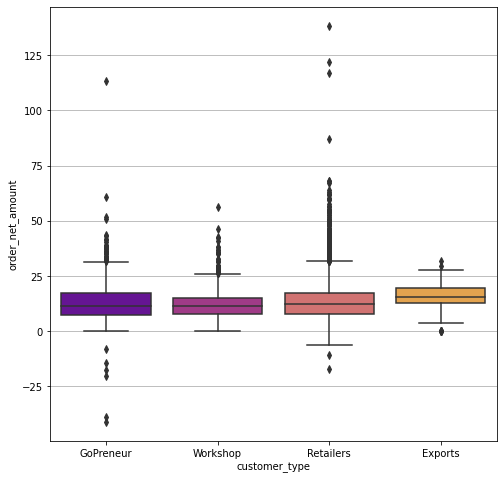

In [109]:
plt.figure(figsize=(8,8))
plt.grid()
sns.boxplot(train_data_['customer_type'], train_data_['order_net_amount'],palette='plasma')
plt.show()

In [110]:
train_data_.groupby('customer_type')['order_net_amount'].median()

customer_type
Exports      15.497704
GoPreneur    11.580805
Retailers    12.416986
Workshop     11.231551
Name: order_net_amount, dtype: float64

## <span style="color:seagreen">Modeling</span>

In [114]:
X_train = train_data_.drop('order_net_amount', axis = 1)
y_train = train_data_['order_net_amount']
X_test = test_data_.drop('order_net_amount', axis = 1)
y_test = test_data_['order_net_amount']

In [115]:
model = CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')

In [116]:
categorical_features_indices = cols_encode

In [117]:
model.fit(X_train, y_train, cat_features=categorical_features_indices, eval_set=(X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 8.2882614	test: 7.9596429	best: 7.9596429 (0)	total: 70.5ms	remaining: 3.46s
1:	learn: 7.9029428	test: 7.5653461	best: 7.5653461 (1)	total: 76.6ms	remaining: 1.84s
2:	learn: 7.5663820	test: 7.2239011	best: 7.2239011 (2)	total: 89.3ms	remaining: 1.4s
3:	learn: 7.2729752	test: 6.9223748	best: 6.9223748 (3)	total: 104ms	remaining: 1.19s
4:	learn: 7.0136178	test: 6.6514407	best: 6.6514407 (4)	total: 110ms	remaining: 994ms
5:	learn: 6.7843520	test: 6.4153562	best: 6.4153562 (5)	total: 119ms	remaining: 873ms
6:	learn: 6.5967715	test: 6.2202734	best: 6.2202734 (6)	total: 125ms	remaining: 768ms
7:	learn: 6.4256550	test: 6.0485271	best: 6.0485271 (7)	total: 133ms	remaining: 698ms
8:	learn: 6.2492823	test: 5.8793167	best: 5.8793167 (8)	total: 139ms	remaining: 632ms
9:	learn: 6.1037553	test: 5.7326817	best: 5.7326817 (9)	total: 145ms	remaining: 580ms
10:	learn: 5.9646386	test: 5.5878160	best: 5.5878160 (10)	total: 152ms	remaining: 538ms
11:	learn: 5.8339572	test: 5.4581220	best: 5.45812

In [118]:
y_pred = model.predict(X_test)

In [119]:
y_pred

array([18.04212051, 20.39304856, 32.01352153, ..., 13.28590236,
        9.96319849, 12.99260946])

In [120]:
r2_score(y_test, y_pred)

0.7968065777128986

In [121]:
## Cross Validation

In [124]:
categorical_features_indices = np.where(X_train.dtypes == np.object)[0];
print(categorical_features_indices)

[2 3 5 6 7 8]


In [125]:
X_train.columns

Index(['amount', 'customer_type', 'items', 'order_status', 'quantity',
       'shipping_state', 'sku_name', 'source', 'warehouse_name',
       'pending_orders', 'overdue_days'],
      dtype='object')

In [126]:
model = CatBoostRegressor(random_seed=42, cat_features = categorical_features_indices)
parameters = {'depth' : [6,8,10],
'learning_rate' : [0.01, 0.05, 0.1],
'iterations' : [30, 50, 100]
}
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2)
grid.fit(X_train, y_train)

0:	learn: 8.4783905	total: 11.4ms	remaining: 331ms
1:	learn: 8.4288563	total: 22ms	remaining: 308ms
2:	learn: 8.3822548	total: 29.1ms	remaining: 262ms
3:	learn: 8.3364663	total: 39ms	remaining: 253ms
4:	learn: 8.2943378	total: 45.2ms	remaining: 226ms
5:	learn: 8.2455237	total: 52.4ms	remaining: 210ms
6:	learn: 8.1984709	total: 59.4ms	remaining: 195ms
7:	learn: 8.1532131	total: 67ms	remaining: 184ms
8:	learn: 8.1089766	total: 73ms	remaining: 170ms
9:	learn: 8.0647364	total: 83ms	remaining: 166ms
10:	learn: 8.0236351	total: 89.1ms	remaining: 154ms
11:	learn: 7.9824791	total: 97.2ms	remaining: 146ms
12:	learn: 7.9406752	total: 104ms	remaining: 136ms
13:	learn: 7.8979178	total: 114ms	remaining: 130ms
14:	learn: 7.8561109	total: 120ms	remaining: 120ms
15:	learn: 7.8137483	total: 128ms	remaining: 112ms
16:	learn: 7.7748822	total: 135ms	remaining: 103ms
17:	learn: 7.7330371	total: 140ms	remaining: 93.6ms
18:	learn: 7.6912049	total: 148ms	remaining: 85.4ms
19:	learn: 7.6537590	total: 153ms	rem

25:	learn: 3.8763005	total: 197ms	remaining: 30.2ms
26:	learn: 3.8351151	total: 204ms	remaining: 22.6ms
27:	learn: 3.7714989	total: 210ms	remaining: 15ms
28:	learn: 3.7239293	total: 216ms	remaining: 7.46ms
29:	learn: 3.6743323	total: 224ms	remaining: 0us
0:	learn: 8.4783905	total: 12.3ms	remaining: 601ms
1:	learn: 8.4288563	total: 24.7ms	remaining: 593ms
2:	learn: 8.3822548	total: 30.8ms	remaining: 483ms
3:	learn: 8.3364663	total: 38.9ms	remaining: 447ms
4:	learn: 8.2943378	total: 45ms	remaining: 405ms
5:	learn: 8.2455237	total: 52.6ms	remaining: 386ms
6:	learn: 8.1984709	total: 58.7ms	remaining: 361ms
7:	learn: 8.1532131	total: 67.1ms	remaining: 352ms
8:	learn: 8.1089766	total: 82.3ms	remaining: 375ms
9:	learn: 8.0647364	total: 93.2ms	remaining: 373ms
10:	learn: 8.0236351	total: 102ms	remaining: 362ms
11:	learn: 7.9824791	total: 108ms	remaining: 343ms
12:	learn: 7.9406752	total: 115ms	remaining: 326ms
13:	learn: 7.8979178	total: 121ms	remaining: 310ms
14:	learn: 7.8561109	total: 127ms

24:	learn: 4.9481187	total: 196ms	remaining: 196ms
25:	learn: 4.8850423	total: 203ms	remaining: 188ms
26:	learn: 4.8260562	total: 210ms	remaining: 179ms
27:	learn: 4.7745159	total: 218ms	remaining: 171ms
28:	learn: 4.7049634	total: 225ms	remaining: 163ms
29:	learn: 4.6507870	total: 236ms	remaining: 157ms
30:	learn: 4.5955483	total: 246ms	remaining: 151ms
31:	learn: 4.5403167	total: 255ms	remaining: 143ms
32:	learn: 4.4852828	total: 262ms	remaining: 135ms
33:	learn: 4.4408739	total: 270ms	remaining: 127ms
34:	learn: 4.4007050	total: 277ms	remaining: 119ms
35:	learn: 4.3520175	total: 286ms	remaining: 111ms
36:	learn: 4.3140834	total: 292ms	remaining: 103ms
37:	learn: 4.2832505	total: 300ms	remaining: 94.8ms
38:	learn: 4.2489237	total: 308ms	remaining: 86.9ms
39:	learn: 4.2157645	total: 315ms	remaining: 78.8ms
40:	learn: 4.1719292	total: 322ms	remaining: 70.7ms
41:	learn: 4.1361401	total: 330ms	remaining: 62.9ms
42:	learn: 4.1000853	total: 337ms	remaining: 54.9ms
43:	learn: 4.0656351	tota

52:	learn: 6.5791758	total: 408ms	remaining: 362ms
53:	learn: 6.5536889	total: 414ms	remaining: 353ms
54:	learn: 6.5285316	total: 420ms	remaining: 344ms
55:	learn: 6.5044149	total: 428ms	remaining: 336ms
56:	learn: 6.4801443	total: 436ms	remaining: 329ms
57:	learn: 6.4555082	total: 442ms	remaining: 320ms
58:	learn: 6.4285144	total: 448ms	remaining: 312ms
59:	learn: 6.4055222	total: 455ms	remaining: 303ms
60:	learn: 6.3798233	total: 461ms	remaining: 295ms
61:	learn: 6.3532161	total: 472ms	remaining: 289ms
62:	learn: 6.3270065	total: 479ms	remaining: 281ms
63:	learn: 6.3009077	total: 487ms	remaining: 274ms
64:	learn: 6.2768263	total: 495ms	remaining: 267ms
65:	learn: 6.2509473	total: 501ms	remaining: 258ms
66:	learn: 6.2258439	total: 508ms	remaining: 250ms
67:	learn: 6.2018897	total: 514ms	remaining: 242ms
68:	learn: 6.1784091	total: 520ms	remaining: 234ms
69:	learn: 6.1556508	total: 528ms	remaining: 226ms
70:	learn: 6.1341577	total: 534ms	remaining: 218ms
71:	learn: 6.1126054	total: 543

24:	learn: 5.2427517	total: 243ms	remaining: 730ms
25:	learn: 5.1804185	total: 249ms	remaining: 709ms
26:	learn: 5.1175940	total: 256ms	remaining: 691ms
27:	learn: 5.0648759	total: 262ms	remaining: 673ms
28:	learn: 5.0191246	total: 268ms	remaining: 655ms
29:	learn: 4.9721794	total: 275ms	remaining: 642ms
30:	learn: 4.9262360	total: 281ms	remaining: 625ms
31:	learn: 4.8908326	total: 288ms	remaining: 612ms
32:	learn: 4.8591053	total: 294ms	remaining: 598ms
33:	learn: 4.8215918	total: 301ms	remaining: 584ms
34:	learn: 4.7843042	total: 307ms	remaining: 571ms
35:	learn: 4.7518579	total: 314ms	remaining: 558ms
36:	learn: 4.7185387	total: 320ms	remaining: 545ms
37:	learn: 4.6673794	total: 331ms	remaining: 540ms
38:	learn: 4.6235904	total: 347ms	remaining: 543ms
39:	learn: 4.5804986	total: 356ms	remaining: 534ms
40:	learn: 4.5424498	total: 362ms	remaining: 520ms
41:	learn: 4.5099493	total: 370ms	remaining: 511ms
42:	learn: 4.4763926	total: 376ms	remaining: 498ms
43:	learn: 4.4432607	total: 383

95:	learn: 3.2274780	total: 715ms	remaining: 29.8ms
96:	learn: 3.2182059	total: 725ms	remaining: 22.4ms
97:	learn: 3.2109733	total: 733ms	remaining: 14.9ms
98:	learn: 3.2033596	total: 738ms	remaining: 7.46ms
99:	learn: 3.1955166	total: 746ms	remaining: 0us
0:	learn: 8.0500755	total: 12.1ms	remaining: 1.2s
1:	learn: 7.6130914	total: 25.3ms	remaining: 1.24s
2:	learn: 7.2441992	total: 32.1ms	remaining: 1.04s
3:	learn: 6.9003713	total: 38.4ms	remaining: 921ms
4:	learn: 6.6095467	total: 45.9ms	remaining: 872ms
5:	learn: 6.3238116	total: 53.3ms	remaining: 835ms
6:	learn: 6.0816421	total: 61.6ms	remaining: 818ms
7:	learn: 5.8519712	total: 67.8ms	remaining: 780ms
8:	learn: 5.6862642	total: 75.5ms	remaining: 764ms
9:	learn: 5.5238566	total: 86.5ms	remaining: 779ms
10:	learn: 5.4398354	total: 91.9ms	remaining: 744ms
11:	learn: 5.2923418	total: 99.1ms	remaining: 727ms
12:	learn: 5.1623339	total: 107ms	remaining: 717ms
13:	learn: 5.0628927	total: 114ms	remaining: 700ms
14:	learn: 4.9559908	total: 

60:	learn: 3.0777304	total: 443ms	remaining: 283ms
61:	learn: 3.0673831	total: 450ms	remaining: 276ms
62:	learn: 3.0570641	total: 458ms	remaining: 269ms
63:	learn: 3.0476592	total: 465ms	remaining: 261ms
64:	learn: 3.0457639	total: 470ms	remaining: 253ms
65:	learn: 3.0405442	total: 475ms	remaining: 245ms
66:	learn: 3.0344482	total: 482ms	remaining: 237ms
67:	learn: 3.0297036	total: 488ms	remaining: 230ms
68:	learn: 3.0197090	total: 494ms	remaining: 222ms
69:	learn: 3.0099872	total: 502ms	remaining: 215ms
70:	learn: 2.9969109	total: 508ms	remaining: 208ms
71:	learn: 2.9884892	total: 515ms	remaining: 200ms
72:	learn: 2.9858137	total: 518ms	remaining: 192ms
73:	learn: 2.9814729	total: 525ms	remaining: 184ms
74:	learn: 2.9729416	total: 532ms	remaining: 177ms
75:	learn: 2.9704787	total: 538ms	remaining: 170ms
76:	learn: 2.9595812	total: 544ms	remaining: 163ms
77:	learn: 2.9468013	total: 551ms	remaining: 155ms
78:	learn: 2.9376112	total: 558ms	remaining: 148ms
79:	learn: 2.9335006	total: 565

4:	learn: 6.5054382	total: 77.3ms	remaining: 386ms
5:	learn: 6.2175432	total: 90.5ms	remaining: 362ms
6:	learn: 5.9447884	total: 105ms	remaining: 345ms
7:	learn: 5.7134174	total: 116ms	remaining: 319ms
8:	learn: 5.4988323	total: 132ms	remaining: 308ms
9:	learn: 5.3356535	total: 143ms	remaining: 285ms
10:	learn: 5.1814204	total: 158ms	remaining: 273ms
11:	learn: 5.0866324	total: 166ms	remaining: 248ms
12:	learn: 4.9820352	total: 181ms	remaining: 236ms
13:	learn: 4.8644183	total: 192ms	remaining: 219ms
14:	learn: 4.7530065	total: 209ms	remaining: 209ms
15:	learn: 4.6603768	total: 220ms	remaining: 193ms
16:	learn: 4.5753715	total: 235ms	remaining: 180ms
17:	learn: 4.4956078	total: 246ms	remaining: 164ms
18:	learn: 4.4519347	total: 259ms	remaining: 150ms
19:	learn: 4.3890520	total: 270ms	remaining: 135ms
20:	learn: 4.3100607	total: 281ms	remaining: 121ms
21:	learn: 4.2340062	total: 296ms	remaining: 108ms
22:	learn: 4.1777760	total: 306ms	remaining: 93.1ms
23:	learn: 4.1226512	total: 322ms	

14:	learn: 5.8555557	total: 204ms	remaining: 475ms
15:	learn: 5.7437863	total: 215ms	remaining: 457ms
16:	learn: 5.6421440	total: 230ms	remaining: 446ms
17:	learn: 5.5419892	total: 240ms	remaining: 426ms
18:	learn: 5.4572094	total: 254ms	remaining: 415ms
19:	learn: 5.3635544	total: 264ms	remaining: 396ms
20:	learn: 5.2783997	total: 277ms	remaining: 383ms
21:	learn: 5.1953135	total: 288ms	remaining: 366ms
22:	learn: 5.1231390	total: 302ms	remaining: 355ms
23:	learn: 5.0558730	total: 312ms	remaining: 338ms
24:	learn: 4.9874606	total: 327ms	remaining: 327ms
25:	learn: 4.9289469	total: 338ms	remaining: 312ms
26:	learn: 4.8798062	total: 354ms	remaining: 301ms
27:	learn: 4.8364735	total: 364ms	remaining: 286ms
28:	learn: 4.7883062	total: 377ms	remaining: 273ms
29:	learn: 4.7414170	total: 388ms	remaining: 258ms
30:	learn: 4.6947561	total: 402ms	remaining: 246ms
31:	learn: 4.6457752	total: 411ms	remaining: 231ms
32:	learn: 4.6012309	total: 426ms	remaining: 219ms
33:	learn: 4.5605009	total: 436

33:	learn: 3.3244869	total: 441ms	remaining: 207ms
34:	learn: 3.2911126	total: 456ms	remaining: 195ms
35:	learn: 3.2716873	total: 466ms	remaining: 181ms
36:	learn: 3.2395386	total: 480ms	remaining: 169ms
37:	learn: 3.2104323	total: 490ms	remaining: 155ms
38:	learn: 3.1837235	total: 506ms	remaining: 143ms
39:	learn: 3.1640711	total: 516ms	remaining: 129ms
40:	learn: 3.1414447	total: 541ms	remaining: 119ms
41:	learn: 3.1273380	total: 550ms	remaining: 105ms
42:	learn: 3.1122575	total: 564ms	remaining: 91.8ms
43:	learn: 3.0951540	total: 574ms	remaining: 78.3ms
44:	learn: 3.0807498	total: 587ms	remaining: 65.2ms
45:	learn: 3.0654799	total: 599ms	remaining: 52.1ms
46:	learn: 3.0479989	total: 611ms	remaining: 39ms
47:	learn: 3.0339554	total: 627ms	remaining: 26.1ms
48:	learn: 3.0112653	total: 637ms	remaining: 13ms
49:	learn: 2.9933525	total: 651ms	remaining: 0us
0:	learn: 8.4745790	total: 14.7ms	remaining: 1.46s
1:	learn: 8.4266390	total: 25.4ms	remaining: 1.25s
2:	learn: 8.3756529	total: 44m

56:	learn: 6.3445020	total: 744ms	remaining: 562ms
57:	learn: 6.3110253	total: 755ms	remaining: 547ms
58:	learn: 6.2805726	total: 770ms	remaining: 535ms
59:	learn: 6.2489469	total: 780ms	remaining: 520ms
60:	learn: 6.2172436	total: 796ms	remaining: 509ms
61:	learn: 6.1844249	total: 806ms	remaining: 494ms
62:	learn: 6.1535827	total: 822ms	remaining: 483ms
63:	learn: 6.1233058	total: 833ms	remaining: 469ms
64:	learn: 6.0937987	total: 850ms	remaining: 458ms
65:	learn: 6.0637964	total: 861ms	remaining: 444ms
66:	learn: 6.0371555	total: 878ms	remaining: 432ms
67:	learn: 6.0112117	total: 888ms	remaining: 418ms
68:	learn: 5.9814541	total: 903ms	remaining: 406ms
69:	learn: 5.9542387	total: 913ms	remaining: 391ms
70:	learn: 5.9261423	total: 928ms	remaining: 379ms
71:	learn: 5.9056062	total: 934ms	remaining: 363ms
72:	learn: 5.8804707	total: 948ms	remaining: 351ms
73:	learn: 5.8540319	total: 959ms	remaining: 337ms
74:	learn: 5.8276972	total: 975ms	remaining: 325ms
75:	learn: 5.8013058	total: 985

21:	learn: 5.0357889	total: 288ms	remaining: 1.02s
22:	learn: 4.9525912	total: 303ms	remaining: 1.01s
23:	learn: 4.8582642	total: 314ms	remaining: 993ms
24:	learn: 4.7786913	total: 330ms	remaining: 989ms
25:	learn: 4.6937746	total: 340ms	remaining: 967ms
26:	learn: 4.6294602	total: 356ms	remaining: 962ms
27:	learn: 4.5613099	total: 366ms	remaining: 941ms
28:	learn: 4.4907144	total: 380ms	remaining: 931ms
29:	learn: 4.4311756	total: 390ms	remaining: 910ms
30:	learn: 4.3760401	total: 406ms	remaining: 905ms
31:	learn: 4.3102001	total: 416ms	remaining: 885ms
32:	learn: 4.2603142	total: 432ms	remaining: 878ms
33:	learn: 4.2107212	total: 443ms	remaining: 859ms
34:	learn: 4.1545680	total: 459ms	remaining: 852ms
35:	learn: 4.1031050	total: 469ms	remaining: 834ms
36:	learn: 4.0550006	total: 485ms	remaining: 826ms
37:	learn: 4.0142773	total: 495ms	remaining: 808ms
38:	learn: 3.9772233	total: 510ms	remaining: 797ms
39:	learn: 3.9458178	total: 519ms	remaining: 779ms
40:	learn: 3.9053114	total: 536

96:	learn: 3.2932719	total: 1.31s	remaining: 40.5ms
97:	learn: 3.2913044	total: 1.32s	remaining: 27ms
98:	learn: 3.2852992	total: 1.33s	remaining: 13.5ms
99:	learn: 3.2836304	total: 1.36s	remaining: 0us
0:	learn: 8.3030687	total: 15.6ms	remaining: 1.55s
1:	learn: 7.7805028	total: 27.1ms	remaining: 1.33s
2:	learn: 7.3048407	total: 41.8ms	remaining: 1.35s
3:	learn: 6.8885564	total: 51.8ms	remaining: 1.24s
4:	learn: 6.5042926	total: 65.2ms	remaining: 1.24s
5:	learn: 6.1846944	total: 75.4ms	remaining: 1.18s
6:	learn: 5.9258725	total: 93ms	remaining: 1.24s
7:	learn: 5.6707597	total: 103ms	remaining: 1.19s
8:	learn: 5.4232014	total: 119ms	remaining: 1.2s
9:	learn: 5.2168451	total: 129ms	remaining: 1.16s
10:	learn: 5.0429122	total: 144ms	remaining: 1.16s
11:	learn: 4.8659235	total: 153ms	remaining: 1.12s
12:	learn: 4.7057418	total: 167ms	remaining: 1.12s
13:	learn: 4.5553355	total: 179ms	remaining: 1.1s
14:	learn: 4.4248579	total: 197ms	remaining: 1.12s
15:	learn: 4.3090749	total: 209ms	remai

0:	learn: 8.2688988	total: 25.7ms	remaining: 746ms
1:	learn: 8.0129671	total: 41.5ms	remaining: 581ms
2:	learn: 7.7817229	total: 59.8ms	remaining: 539ms
3:	learn: 7.5660037	total: 84.3ms	remaining: 548ms
4:	learn: 7.3600852	total: 108ms	remaining: 540ms
5:	learn: 7.1659263	total: 133ms	remaining: 531ms
6:	learn: 6.9783514	total: 155ms	remaining: 511ms
7:	learn: 6.8229260	total: 161ms	remaining: 442ms
8:	learn: 6.6687204	total: 185ms	remaining: 431ms
9:	learn: 6.5129600	total: 192ms	remaining: 385ms
10:	learn: 6.3643056	total: 218ms	remaining: 377ms
11:	learn: 6.2192662	total: 254ms	remaining: 381ms
12:	learn: 6.0767485	total: 316ms	remaining: 413ms
13:	learn: 5.9417141	total: 346ms	remaining: 396ms
14:	learn: 5.8241808	total: 364ms	remaining: 364ms
15:	learn: 5.7214979	total: 389ms	remaining: 341ms
16:	learn: 5.6076976	total: 416ms	remaining: 318ms
17:	learn: 5.5119604	total: 443ms	remaining: 296ms
18:	learn: 5.4090959	total: 468ms	remaining: 271ms
19:	learn: 5.3187661	total: 483ms	rem

0:	learn: 8.8190565	total: 12.4ms	remaining: 608ms
1:	learn: 8.7606759	total: 35.2ms	remaining: 846ms
2:	learn: 8.7049843	total: 60ms	remaining: 939ms
3:	learn: 8.6492778	total: 71.4ms	remaining: 821ms
4:	learn: 8.5908936	total: 93.7ms	remaining: 843ms
5:	learn: 8.5363318	total: 102ms	remaining: 750ms
6:	learn: 8.4812858	total: 118ms	remaining: 725ms
7:	learn: 8.4277519	total: 142ms	remaining: 744ms
8:	learn: 8.3729701	total: 163ms	remaining: 742ms
9:	learn: 8.3192630	total: 184ms	remaining: 736ms
10:	learn: 8.2630069	total: 209ms	remaining: 742ms
11:	learn: 8.2104062	total: 235ms	remaining: 745ms
12:	learn: 8.1607360	total: 257ms	remaining: 732ms
13:	learn: 8.1104979	total: 262ms	remaining: 674ms
14:	learn: 8.0620940	total: 284ms	remaining: 663ms
15:	learn: 8.0096050	total: 291ms	remaining: 618ms
16:	learn: 7.9614806	total: 317ms	remaining: 616ms
17:	learn: 7.9098833	total: 339ms	remaining: 602ms
18:	learn: 7.8614005	total: 352ms	remaining: 574ms
19:	learn: 7.8117952	total: 373ms	rema

15:	learn: 4.5624294	total: 423ms	remaining: 900ms
16:	learn: 4.4770509	total: 446ms	remaining: 866ms
17:	learn: 4.4147134	total: 455ms	remaining: 809ms
18:	learn: 4.3590197	total: 463ms	remaining: 755ms
19:	learn: 4.3089629	total: 490ms	remaining: 734ms
20:	learn: 4.2354450	total: 523ms	remaining: 722ms
21:	learn: 4.1823894	total: 528ms	remaining: 671ms
22:	learn: 4.1090162	total: 551ms	remaining: 647ms
23:	learn: 4.0410641	total: 578ms	remaining: 626ms
24:	learn: 3.9773482	total: 628ms	remaining: 628ms
25:	learn: 3.9278070	total: 658ms	remaining: 608ms
26:	learn: 3.8788061	total: 687ms	remaining: 585ms
27:	learn: 3.8391511	total: 711ms	remaining: 558ms
28:	learn: 3.8053382	total: 738ms	remaining: 535ms
29:	learn: 3.7805216	total: 750ms	remaining: 500ms
30:	learn: 3.7493080	total: 773ms	remaining: 474ms
31:	learn: 3.7215515	total: 803ms	remaining: 451ms
32:	learn: 3.7149126	total: 805ms	remaining: 415ms
33:	learn: 3.6907091	total: 845ms	remaining: 398ms
34:	learn: 3.6601145	total: 878

78:	learn: 5.7708654	total: 1.59s	remaining: 424ms
79:	learn: 5.7465843	total: 1.61s	remaining: 404ms
80:	learn: 5.7251660	total: 1.64s	remaining: 384ms
81:	learn: 5.7034501	total: 1.66s	remaining: 364ms
82:	learn: 5.6811519	total: 1.68s	remaining: 345ms
83:	learn: 5.6620590	total: 1.69s	remaining: 322ms
84:	learn: 5.6433645	total: 1.71s	remaining: 302ms
85:	learn: 5.6229066	total: 1.73s	remaining: 282ms
86:	learn: 5.6022132	total: 1.75s	remaining: 262ms
87:	learn: 5.5808981	total: 1.77s	remaining: 242ms
88:	learn: 5.5610546	total: 1.79s	remaining: 222ms
89:	learn: 5.5413488	total: 1.82s	remaining: 202ms
90:	learn: 5.5220684	total: 1.84s	remaining: 182ms
91:	learn: 5.5010797	total: 1.86s	remaining: 162ms
92:	learn: 5.4802646	total: 1.88s	remaining: 142ms
93:	learn: 5.4606790	total: 1.9s	remaining: 121ms
94:	learn: 5.4414683	total: 1.92s	remaining: 101ms
95:	learn: 5.4232093	total: 1.94s	remaining: 81ms
96:	learn: 5.4041197	total: 1.97s	remaining: 60.8ms
97:	learn: 5.3847208	total: 1.99

42:	learn: 4.1726363	total: 1.02s	remaining: 1.35s
43:	learn: 4.1358427	total: 1.04s	remaining: 1.32s
44:	learn: 4.0986831	total: 1.06s	remaining: 1.3s
45:	learn: 4.0683449	total: 1.09s	remaining: 1.28s
46:	learn: 4.0342862	total: 1.12s	remaining: 1.26s
47:	learn: 4.0080972	total: 1.13s	remaining: 1.23s
48:	learn: 3.9741401	total: 1.16s	remaining: 1.21s
49:	learn: 3.9496093	total: 1.18s	remaining: 1.18s
50:	learn: 3.9262491	total: 1.21s	remaining: 1.16s
51:	learn: 3.9009766	total: 1.23s	remaining: 1.13s
52:	learn: 3.8800557	total: 1.25s	remaining: 1.11s
53:	learn: 3.8586221	total: 1.28s	remaining: 1.09s
54:	learn: 3.8388622	total: 1.3s	remaining: 1.06s
55:	learn: 3.8186503	total: 1.32s	remaining: 1.04s
56:	learn: 3.8009755	total: 1.35s	remaining: 1.02s
57:	learn: 3.7847072	total: 1.39s	remaining: 1.01s
58:	learn: 3.7631567	total: 1.42s	remaining: 989ms
59:	learn: 3.7467493	total: 1.45s	remaining: 965ms
60:	learn: 3.7337255	total: 1.48s	remaining: 946ms
61:	learn: 3.7194601	total: 1.53s

11:	learn: 4.9745374	total: 256ms	remaining: 1.88s
12:	learn: 4.8536774	total: 281ms	remaining: 1.88s
13:	learn: 4.7448879	total: 305ms	remaining: 1.87s
14:	learn: 4.6594284	total: 327ms	remaining: 1.85s
15:	learn: 4.5624294	total: 350ms	remaining: 1.84s
16:	learn: 4.4770509	total: 375ms	remaining: 1.83s
17:	learn: 4.4147134	total: 399ms	remaining: 1.82s
18:	learn: 4.3590197	total: 415ms	remaining: 1.77s
19:	learn: 4.3089629	total: 447ms	remaining: 1.79s
20:	learn: 4.2354450	total: 477ms	remaining: 1.79s
21:	learn: 4.1823894	total: 482ms	remaining: 1.71s
22:	learn: 4.1090162	total: 505ms	remaining: 1.69s
23:	learn: 4.0410641	total: 535ms	remaining: 1.69s
24:	learn: 3.9773482	total: 557ms	remaining: 1.67s
25:	learn: 3.9278070	total: 582ms	remaining: 1.66s
26:	learn: 3.8788061	total: 607ms	remaining: 1.64s
27:	learn: 3.8391511	total: 633ms	remaining: 1.63s
28:	learn: 3.8053382	total: 659ms	remaining: 1.61s
29:	learn: 3.7805216	total: 667ms	remaining: 1.56s
30:	learn: 3.7493080	total: 688

76:	learn: 2.5220064	total: 1.56s	remaining: 467ms
77:	learn: 2.5178291	total: 1.58s	remaining: 447ms
78:	learn: 2.5079018	total: 1.61s	remaining: 427ms
79:	learn: 2.5062836	total: 1.61s	remaining: 403ms
80:	learn: 2.4952023	total: 1.63s	remaining: 383ms
81:	learn: 2.4816429	total: 1.65s	remaining: 363ms
82:	learn: 2.4742671	total: 1.67s	remaining: 343ms
83:	learn: 2.4736992	total: 1.68s	remaining: 320ms
84:	learn: 2.4706253	total: 1.7s	remaining: 300ms
85:	learn: 2.4656452	total: 1.72s	remaining: 280ms
86:	learn: 2.4578859	total: 1.74s	remaining: 260ms
87:	learn: 2.4547230	total: 1.76s	remaining: 240ms
88:	learn: 2.4488234	total: 1.78s	remaining: 220ms
89:	learn: 2.4487642	total: 1.78s	remaining: 198ms
90:	learn: 2.4435048	total: 1.81s	remaining: 179ms
91:	learn: 2.4305988	total: 1.83s	remaining: 159ms
92:	learn: 2.4185398	total: 1.85s	remaining: 140ms
93:	learn: 2.4077753	total: 1.88s	remaining: 120ms
94:	learn: 2.4028981	total: 1.9s	remaining: 100ms
95:	learn: 2.3917025	total: 1.92s

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000020D900FB0A0>,
             param_grid={'depth': [6, 8, 10], 'iterations': [30, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]})

In [127]:
grid.best_params_

{'depth': 6, 'iterations': 100, 'learning_rate': 0.1}

In [128]:
model = CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, loss_function='RMSE', cat_features = categorical_features_indices)

In [129]:
model.fit(X_train, y_train, cat_features=categorical_features_indices, eval_set=(X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 8.1513547	test: 7.8277845	best: 7.8277845 (0)	total: 30.3ms	remaining: 3s
1:	learn: 7.6532335	test: 7.3198121	best: 7.3198121 (1)	total: 49ms	remaining: 2.4s
2:	learn: 7.2370603	test: 6.9018639	best: 6.9018639 (2)	total: 67.7ms	remaining: 2.19s
3:	learn: 6.8637423	test: 6.5232138	best: 6.5232138 (3)	total: 79.3ms	remaining: 1.9s
4:	learn: 6.5205730	test: 6.1798881	best: 6.1798881 (4)	total: 91.7ms	remaining: 1.74s
5:	learn: 6.2222449	test: 5.8695486	best: 5.8695486 (5)	total: 104ms	remaining: 1.63s
6:	learn: 5.9615016	test: 5.6050929	best: 5.6050929 (6)	total: 114ms	remaining: 1.51s
7:	learn: 5.7351592	test: 5.3721453	best: 5.3721453 (7)	total: 125ms	remaining: 1.44s
8:	learn: 5.5578097	test: 5.1880012	best: 5.1880012 (8)	total: 137ms	remaining: 1.39s
9:	learn: 5.3906261	test: 5.0170256	best: 5.0170256 (9)	total: 150ms	remaining: 1.35s
10:	learn: 5.2401537	test: 4.8714052	best: 4.8714052 (10)	total: 161ms	remaining: 1.3s
11:	learn: 5.0990690	test: 4.7350851	best: 4.7350851 (1

In [130]:
y_pred = model.predict(X_test)

In [131]:
r2_score(y_test, y_pred)

0.8630006052572483

In [143]:
X_train

,amount,customer_type,items,order_status,quantity,shipping_state,sku_name,source,warehouse_name,pending_orders,overdue_days
0,7.568266,1,MGP,Invoiced,10.0,Gujarat,LINING FRONT FENDER RH,Offline,GM_DEL,0,0
1,28.605119,1,VW GROUP,Invoiced,15.0,Gujarat,GRILLE UPPER,Offline,GM_DEL,0,0
2,13.194492,1,VW GROUP,Invoiced,5.0,Gujarat,GRILLE LOWER,Offline,GM_DEL,0,0
3,20.142984,1,VW GROUP,Invoiced,2.0,Gujarat,COVER,Offline,GM_DEL,0,0
4,25.230953,1,VW GROUP,Invoiced,3.0,Gujarat,HOOD,Offline,GM_DEL,0,0
...,...,...,...,...,...,...,...,...,...,...,...
14960,0.000000,2,MGP,Open,2.0,Maharashtra,DISCCLUTCH(SWIFT PETROL),Offline,GM_BOM,1,1
14961,0.000000,2,MGP,Open,3.0,Maharashtra,CLUTCH DISC NEW WAGON-R,Offline,GM_BOM,1,1
14962,0.000000,2,MGP,Open,3.0,Maharashtra,"COVER ASSY,CLUTCH",Offline,GM_BOM,1,1
14963,0.000000,2,MGP,Open,4.0,Maharashtra,BEARINGFRONT WHEEL,Offline,GM_BOM,1,1


In [145]:
test_data_.head()

,amount,customer_type,items,order_status,quantity,shipping_state,sku_name,source,warehouse_name,pending_orders,overdue_days,order_net_amount
8,15.275916,1,VW GROUP,Invoiced,13.0,Gujarat,FENDER,Offline,GM_DEL,0,0,35.918786
9,21.712852,1,VW GROUP,Invoiced,3.0,Gujarat,FENDER,Offline,GM_DEL,0,0,21.712883
12,33.769888,1,VW GROUP,Invoiced,10.0,Gujarat,BUMPER COVER,Offline,GM_DEL,0,0,33.769882
14,11.744627,1,MGP,Invoiced,1.0,Maharashtra,BUMPER FRONT,Offline,GM_DEL,0,0,11.744603
16,11.744627,1,MGP,Invoiced,2.0,Maharashtra,"BUMPER, FRONT (BLACK)",Offline,GM_DEL,0,0,14.797272


In [133]:
model.predict([33.769888, 1, "MGP", 'Invoiced', 10.0, 'Maharashtra', 'BUMPER, FRONT (BLACK)', 'Offline', 'GM_DEL', 0, 0])

31.259298897326165

In [134]:
def cube(x):
    return x**3

In [135]:
predictions = pd.Series(y_pred).apply(lambda x:cube(x))

In [136]:
predictions

0        5667.766662
1       10480.553529
2       39164.291958
3        1724.761935
4        1725.126722
            ...     
4485      564.055152
4486     2154.535934
4487     2439.434292
4488      581.875710
4489     2084.278568
Length: 4490, dtype: float64

## Deployment

In [137]:
pickle_out = open("model.pkl", "wb") 
pickle.dump(model, pickle_out) 
pickle_out.close()